# Preprocessing pipeline

## Outline

<img src="static/preprocessing_pipeline_diagram.svg">

1. __Temporal filtering__

High-frequency artefacts and slow drifts are removed with a zero-phase bandpass filter 
using mne-Python [1]. 

2. __Segmenting the data__

Epochs are non-overlapping data segments created from the continuous data with a 
given duration.
Epochs can be created from (1) events; there is a custom method that created epochs 
based on annotations in the raw data, (2) without events, data segments are created 
from the beginning of the raw data. 

3. __Outlier data rejection__  

- _Preliminar rejection_

Epochs are rejected based on a global threshold on the z-score (> 3) of the epoch 
variance and amplitude range.

- _ICA decomposition_  

The default method is the infomax algorithm, however it can be changed in the 
configuration file along with the number of components and the decimation parameter. 
Components containing blink artefacts are automatically marked with mne-Python.
The ICA sourced can be visualized and interactively selected and rejected based on 
their topographies, time-courses or frequency spectra.

- _Autoreject_  

Autoreject [2, 3] uses unsupervised learning to estimate the rejection threshold for 
the epochs. In order to reduce computation time that increases with the number of 
segments and channels, autoreject can be fitted on a representative subset of epochs 
(25% of total epochs). Once the parameters are learned, the solution can be applied to 
any data that contains channels that were used during fit.

4. __Outlier channel interpolation__

The Random Sample Consensus (RANSAC) algorithm [4] selects a random subsample of good 
channels to make predictions of each channel in small non-overlapping 4 seconds long 
time windows. It uses a method of spherical splines (Perrin et al., 1989) to 
interpolate the bad sensors.


#### References

[1] A. Gramfort, M. Luessi, E. Larson, D. Engemann, D. Strohmeier, C. Brodbeck, R. Goj, M. Jas, T. Brooks, L. Parkkonen, M. Hämäläinen, MEG and EEG data analysis with MNE-Python, Frontiers in Neuroscience, Volume 7, 2013, ISSN 1662-453X

[2] Mainak Jas, Denis Engemann, Federico Raimondo, Yousra Bekhti, and Alexandre Gramfort, “Automated rejection and repair of bad trials in MEG/EEG.” In 6th International Workshop on Pattern Recognition in Neuroimaging (PRNI), 2016.

[3] Mainak Jas, Denis Engemann, Yousra Bekhti, Federico Raimondo, and Alexandre Gramfort. 2017. “Autoreject: Automated artifact rejection for MEG and EEG data”. NeuroImage, 159, 417-429.

[4] Bigdely-Shamlo, N., Mullen, T., Kothe, C., Su, K. M., & Robbins, K. A. (2015). The PREP pipeline: standardized preprocessing for large-scale EEG analysis. Frontiers in neuroinformatics, 9, 16.



## Import packages


```%matplotlib qt``` is the recommended backend for interactive visualization (can be slower);    

switch to ```%matplotlib inline``` for faster but static plots

In [112]:
import os
from pathlib import Path

from ipyfilechooser import FileChooser
import pandas as pd

from meeg_tools.preprocessing import *
from meeg_tools.utils.epochs import create_epochs_from_intervals
from meeg_tools.utils.raw import read_raw_measurement, filter_raw, concat_raws_with_suffix
from meeg_tools.utils.log import update_log

%matplotlib qt

# Load raw data

See [this](https://mne.tools/stable/auto_tutorials/io/20_reading_eeg_data.html) documentation for help with supported file formats.  


In [68]:
# Use the widget to navigate to the experiment folder path and select an EEG file 
base_path = '/Users/weian/Downloads/Raw_data/'
fc = FileChooser(base_path)
fc.filter_pattern = ['*.vhdr', '*.edf']

display(fc)

FileChooser(path='/Users/weian/Downloads/Raw_data', filename='', title='', show_hidden=False, select_desc='Sel…

In [113]:
# Load selected file (when the data was recorded in one piece i.e. there is only one recording in the folder)
raw = read_raw_measurement(raw_file_path=fc.selected)

Extracting parameters from /Users/weian/Downloads/Raw_data/21_E/Day1/EEG/21_E_Day1.vhdr...
Setting channel info structure...
<Info | 9 non-empty values
 bads: []
 ch_names: Fp1, Fz, F3, F7, FT9, FC5, FC1, C3, T7, TP9, CP5, CP1, Pz, P3, ...
 chs: 64 EEG
 custom_ref_applied: False
 dig: 64 items (64 EEG)
 highpass: 0.0 Hz
 lowpass: 1000.0 Hz
 meas_date: 2021-01-14 14:33:24 UTC
 nchan: 64
 projs: []
 sfreq: 500.0 Hz
 temp: 21_E_Day1
>


## Concatenate raw data

We can use this function when there was an issue with the recording and there are multiple EEG recordings for one measurement.


In [71]:
# note that we choose a folder and NOT a file name as before
raws_folder_path = '/Users/weian/Downloads/EEG-3/'

# with the suffix argument we specify what kind of files to look for
raw = concat_raws_with_suffix(path_to_raw_files=raws_folder_path, suffix='.vhdr')

Found 2 files with .vhdr extension:
/Users/weian/Downloads/EEG-3/test1/111_R_Day1.vhdr, /Users/weian/Downloads/EEG-3/test2/111_R_Day1-2.vhdr
Extracting parameters from /Users/weian/Downloads/EEG-3/test1/111_R_Day1.vhdr...
Setting channel info structure...
Extracting parameters from /Users/weian/Downloads/EEG-3/test2/111_R_Day1-2.vhdr...
Setting channel info structure...
<Info | 9 non-empty values
 bads: []
 ch_names: Fp1, Fz, F3, F7, FT9, FC5, FC1, C3, T7, TP9, CP5, CP1, Pz, P3, ...
 chs: 64 EEG
 custom_ref_applied: False
 dig: 64 items (64 EEG)
 highpass: 0.0 Hz
 lowpass: 1000.0 Hz
 meas_date: 2021-07-05 10:29:58 UTC
 nchan: 64
 projs: []
 sfreq: 500.0 Hz
 temp: 111_R_Day1
>


In [ ]:
#raw.copy().crop(tmin=600, tmax=1200).plot()

## Select condition

The current logic for saving the preprocessed files is to create subfolders inside `base_path`,
with the name "preprocessed" and the name of the condition (e.g. "epochs_asrt", "epochs_rs").

In [114]:
condition = 'epochs_rs'


# Create folder for preprocessed and interim files
folder_name = 'preprocessed'
epochs_path = os.path.join(base_path, folder_name, condition)


# Create path to epoch files
if not os.path.exists(epochs_path):
    os.makedirs(epochs_path)
    
print(epochs_path)

/Users/weian/Downloads/Raw_data/preprocessed/epochs_rs


### Load the log file if it already exists

We can check the list of preprocessed files by reading the log file within this notebook with `pandas`

In [173]:
os.listdir(epochs_path)

['log.csv',
 '21_E_Day1_ICA_autoreject_ransac-epo.fif.gz',
 '21_E_Day1_ICA-epo.fif.gz',
 '21_E_Day1_ICA_autoreject-epo.fif.gz']

In [174]:
pd.read_csv(os.path.join(epochs_path, 'log.csv')) if 'log.csv' in os.listdir(epochs_path) else None

fid  highpass  lowpass  n_components  \
0                    21_E_Day1_ICA       0.5     45.0           3.0   
1         21_E_Day1_ICA_autoreject       0.5     45.0           3.0   
2  21_E_Day1_ICA_autoreject_ransac       0.5     45.0           3.0   

   n_bad_epochs  n_total_epochs  drop_percentage       stimuli  t_min  t_max  \
0            15             285             5.00  ['83', '87']    0.0    2.0   
1            77             223            25.67  ['83', '87']    0.0    2.0   
2            77             223            25.67  ['83', '87']    0.0    2.0   

   n_interpolated  average_ref_applied  baseline  notes  \
0             NaN                False       NaN    NaN   
1             NaN                False       NaN    NaN   
2             2.0                 True       NaN    NaN   

               date_of_update  
0  2022-02-09T15:49:44.469880  
1  2022-02-09T15:52:40.953559  
2  2022-02-09T16:10:57.866220

## Temporal filtering

We apply a bandpass filter on the continuous data using the `filter_raw` function.

The default parameters can be checked with `settings['bandpass_filter']`

In [117]:
settings['bandpass_filter']

{'low_freq': 0.5, 'high_freq': 45}

In [118]:
raw_bandpass = filter_raw(raw=raw)

Reading 0 ... 3197309  =      0.000 ...  6394.618 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 3301 samples (6.602 sec)



[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  10 tasks      | elapsed:    7.3s
[Parallel(n_jobs=8)]: Done  64 out of  64 | elapsed:   15.7s finished


## Create epochs
### B. Create epochs with a fixed duration
- not relative to stimulus onset

For this we are using the `settings['epochs']['duration']` setting.

B. 1. Epochs are created based on a stimulus interval

In [119]:
settings['epochs']['duration'] = 2

In [120]:
epochs = create_epochs_from_intervals(raw_bandpass, [(83, 84), (87, 88)])

Used Annotations descriptions: ['New Segment/', 'Stimulus/S  5', 'Stimulus/S 10', 'Stimulus/S 11', 'Stimulus/S 12', 'Stimulus/S 14', 'Stimulus/S 15', 'Stimulus/S 16', 'Stimulus/S 17', 'Stimulus/S 18', 'Stimulus/S 19', 'Stimulus/S 20', 'Stimulus/S 21', 'Stimulus/S 22', 'Stimulus/S 24', 'Stimulus/S 25', 'Stimulus/S 26', 'Stimulus/S 27', 'Stimulus/S 28', 'Stimulus/S 29', 'Stimulus/S 30', 'Stimulus/S 31', 'Stimulus/S 32', 'Stimulus/S 34', 'Stimulus/S 35', 'Stimulus/S 36', 'Stimulus/S 37', 'Stimulus/S 38', 'Stimulus/S 40', 'Stimulus/S 41', 'Stimulus/S 42', 'Stimulus/S 43', 'Stimulus/S 44', 'Stimulus/S 45', 'Stimulus/S 46', 'Stimulus/S 47', 'Stimulus/S 48', 'Stimulus/S 49', 'Stimulus/S 51', 'Stimulus/S 52', 'Stimulus/S 61', 'Stimulus/S 62', 'Stimulus/S 63', 'Stimulus/S 64', 'Stimulus/S 65', 'Stimulus/S 66', 'Stimulus/S 67', 'Stimulus/S 68', 'Stimulus/S 70', 'Stimulus/S 71', 'Stimulus/S 72', 'Stimulus/S 75', 'Stimulus/S 76', 'Stimulus/S 77', 'Stimulus/S 78', 'Stimulus/S 80', 'Stimulus/S 81', 

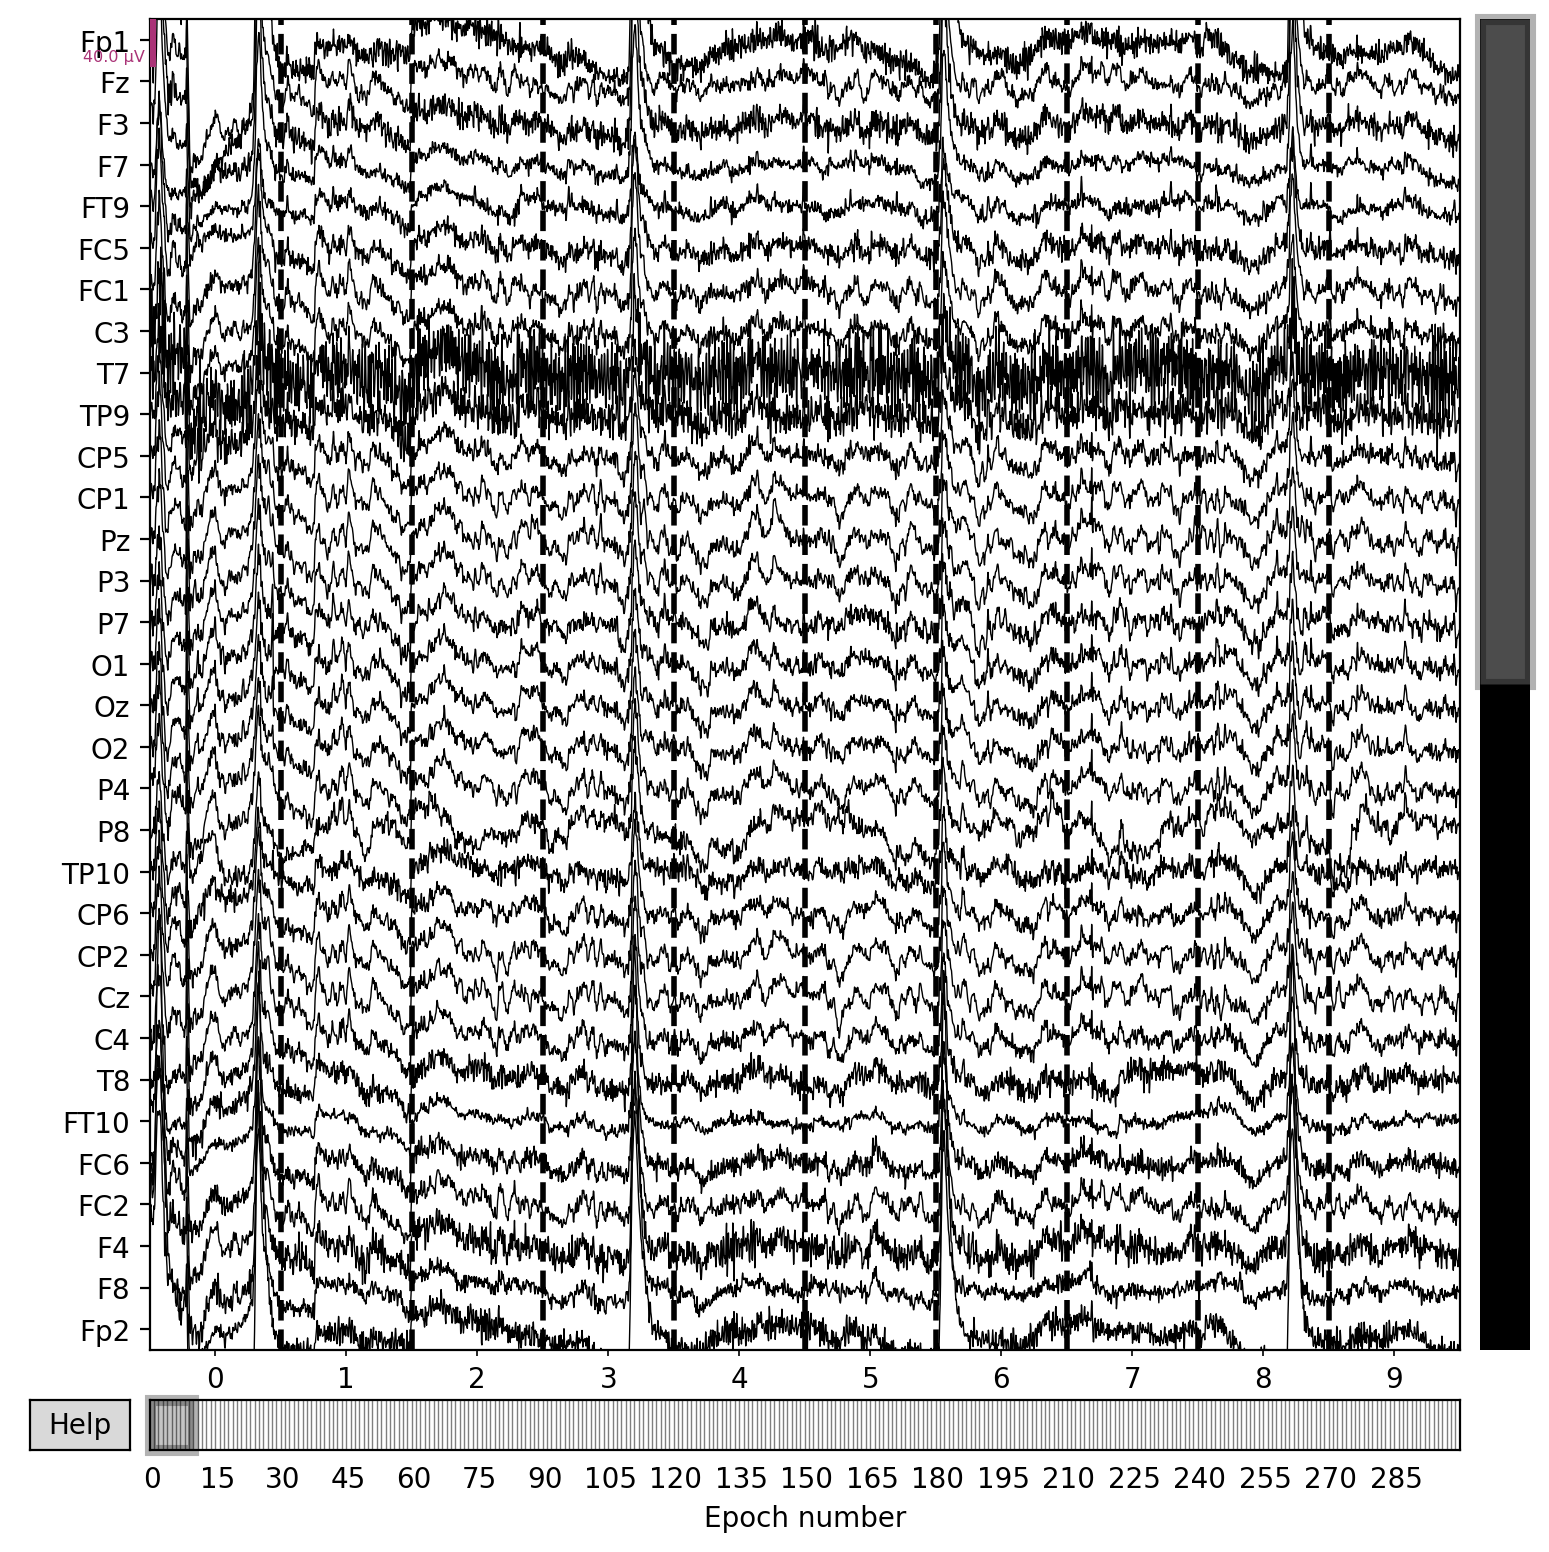

Dropped 0 epochs: 
Channels marked as bad: none
Dropped 0 epochs: 
Channels marked as bad: none


In [87]:
epochs.plot(n_epochs=10, n_channels=32)

## Run preprocessing


### 1.1. Preliminary epoch rejection

In [121]:
epochs_faster = prepare_epochs_for_ica(epochs=epochs)

Preliminary epoch rejection: 
Bad epochs by amplitude
	[  0  47 102 103 260]
Bad epochs by deviation
	[ 23  47  48  58  59  61 150 151 260]
Bad epochs by variance
	[  0  47  60  76 102 103 151 183 260]
Dropped 15 epochs: 0, 23, 47, 48, 58, 59, 60, 61, 76, 102, 103, 150, 151, 183, 260


In [ ]:
epochs_faster.plot_drop_log()

### 1.2. Run ICA


When visualizing the components, it is recommended to subset the data (see below).


Picard can be used to solve the same problems as FastICA, Infomax, and extended Infomax, but typically converges faster than either of those methods. To make use of Picard’s speed while still obtaining the same solution as with other algorithms, you need to specify method='picard' and fit_params as a dictionary with the following combination of keys:

dict(ortho=False, extended=False) for Infomax  

dict(ortho=False, extended=True) for extended Infomax  

dict(ortho=True, extended=True) for FastICA


In [123]:
settings["ica"]

settings["ica"]["method"] = 'picard'
settings["ica"]["decim"] = None

In [124]:
ica = run_ica(epochs_faster, fit_params=dict(ortho=False, extended=True))

Fitting ICA to data using 64 channels (please be patient, this may take a while)


/Users/weian/.conda/envs/eeg-workshop/lib/python3.7/site-packages/mne/utils/check.py:92: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  LooseVersion(library.__version__) < LooseVersion(min_version):
/Users/weian/.conda/envs/eeg-workshop/lib/python3.7/site-packages/mne/utils/check.py:92: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  LooseVersion(library.__version__) < LooseVersion(min_version):


Selecting by number: 32 components
Fitting ICA took 31.9s.
EOG channels are not found. Attempting to use Fp1,Fp2 channels as EOG channels.
Using EOG channels: Fp1, Fp2


In [125]:
# Plot component topographies
#ica.plot_components()


Not setting metadata
Not setting metadata
139 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped


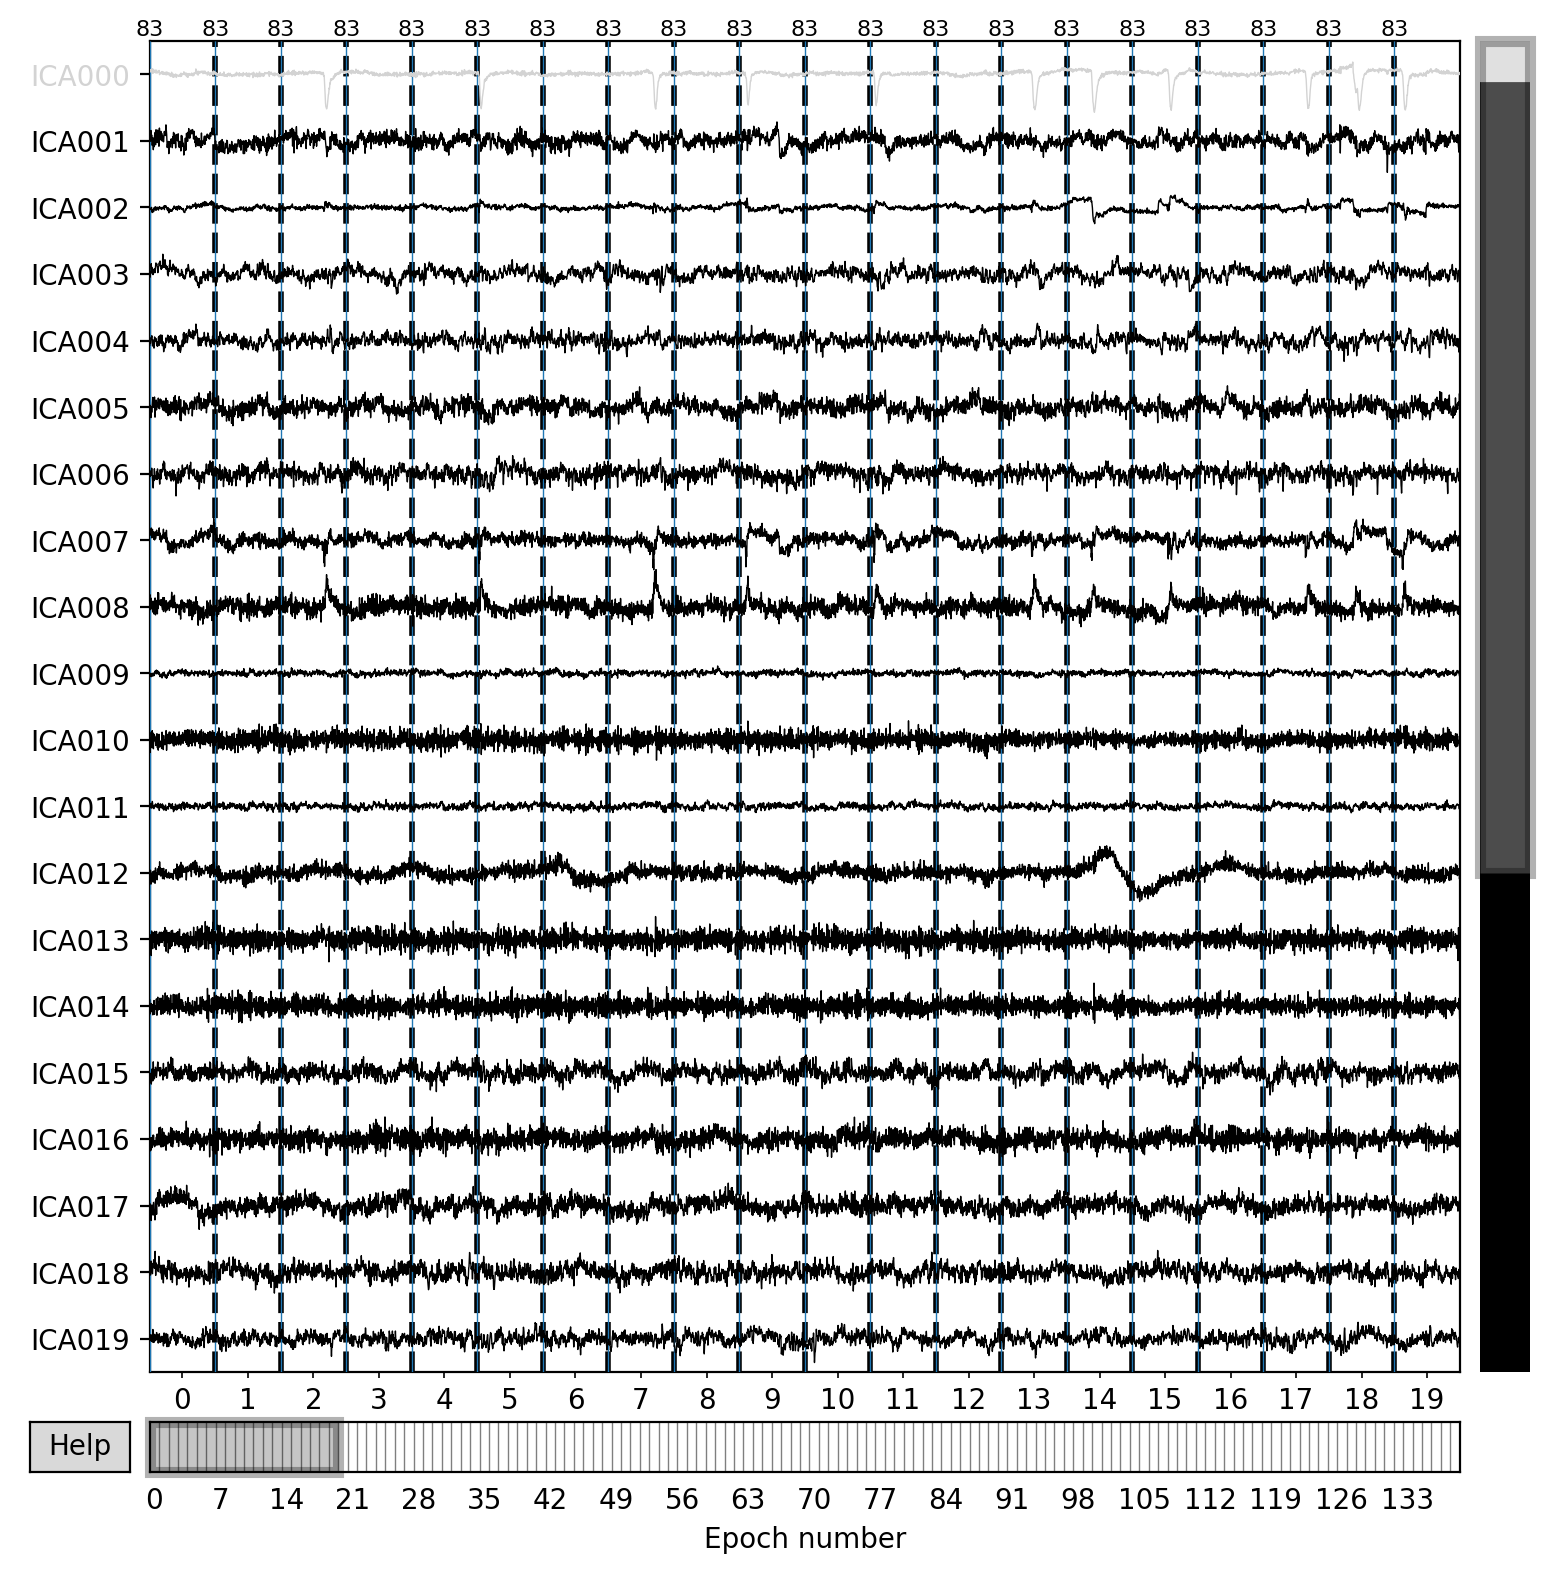

    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
Not setting metadata
139 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Not setting metadata
Not setting metadata
139 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped


/Users/weian/.conda/envs/eeg-workshop/lib/python3.7/site-packages/mne/utils/check.py:92: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  LooseVersion(library.__version__) < LooseVersion(min_version):
/Users/weian/.conda/envs/eeg-workshop/lib/python3.7/site-packages/mne/utils/check.py:92: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  LooseVersion(library.__version__) < LooseVersion(min_version):


    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
Not setting metadata
139 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Not setting metadata
Not setting metadata
139 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped


/Users/weian/.conda/envs/eeg-workshop/lib/python3.7/site-packages/mne/utils/check.py:92: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  LooseVersion(library.__version__) < LooseVersion(min_version):
/Users/weian/.conda/envs/eeg-workshop/lib/python3.7/site-packages/mne/utils/check.py:92: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  LooseVersion(library.__version__) < LooseVersion(min_version):


    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
Not setting metadata
139 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Not setting metadata
Not setting metadata
139 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped


/Users/weian/.conda/envs/eeg-workshop/lib/python3.7/site-packages/mne/utils/check.py:92: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  LooseVersion(library.__version__) < LooseVersion(min_version):
/Users/weian/.conda/envs/eeg-workshop/lib/python3.7/site-packages/mne/utils/check.py:92: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  LooseVersion(library.__version__) < LooseVersion(min_version):


    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
Not setting metadata
139 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Not setting metadata
Not setting metadata
139 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped


/Users/weian/.conda/envs/eeg-workshop/lib/python3.7/site-packages/mne/utils/check.py:92: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  LooseVersion(library.__version__) < LooseVersion(min_version):
/Users/weian/.conda/envs/eeg-workshop/lib/python3.7/site-packages/mne/utils/check.py:92: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  LooseVersion(library.__version__) < LooseVersion(min_version):


    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
Not setting metadata
139 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Not setting metadata
Not setting metadata
139 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped


/Users/weian/.conda/envs/eeg-workshop/lib/python3.7/site-packages/mne/utils/check.py:92: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  LooseVersion(library.__version__) < LooseVersion(min_version):
/Users/weian/.conda/envs/eeg-workshop/lib/python3.7/site-packages/mne/utils/check.py:92: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  LooseVersion(library.__version__) < LooseVersion(min_version):


    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
Not setting metadata
139 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Not setting metadata
Not setting metadata
139 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped


/Users/weian/.conda/envs/eeg-workshop/lib/python3.7/site-packages/mne/utils/check.py:92: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  LooseVersion(library.__version__) < LooseVersion(min_version):
/Users/weian/.conda/envs/eeg-workshop/lib/python3.7/site-packages/mne/utils/check.py:92: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  LooseVersion(library.__version__) < LooseVersion(min_version):


    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
Not setting metadata
139 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Not setting metadata
Not setting metadata
139 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped


/Users/weian/.conda/envs/eeg-workshop/lib/python3.7/site-packages/mne/utils/check.py:92: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  LooseVersion(library.__version__) < LooseVersion(min_version):
/Users/weian/.conda/envs/eeg-workshop/lib/python3.7/site-packages/mne/utils/check.py:92: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  LooseVersion(library.__version__) < LooseVersion(min_version):


In [126]:
# Visualize components on epochs
# Subset epochs to reduce execution time (e.g. take epochs from every 7th event)
subset = list(epochs.event_id.keys())[::7]
# Exclude components by selecting them, right click on component name to visualize source:
ica.plot_sources(epochs_faster[subset])

In [127]:
ica.exclude

[0, 2, 7]

In [128]:
# After selecting the components to exclude, apply ICA to epochs
epochs_ica = apply_ica(epochs_faster, ica)

Applying ICA to Epochs instance
    Transforming to ICA space (32 components)
    Zeroing out 3 ICA components
    Projecting back using 64 PCA components


In [129]:
print(epochs_ica.info)

<Info | 10 non-empty values
 bads: []
 ch_names: Fp1, Fz, F3, F7, FT9, FC5, FC1, C3, T7, TP9, CP5, CP1, Pz, P3, ...
 chs: 64 EEG
 custom_ref_applied: False
 description: n_components: 3
 dig: 64 items (64 EEG)
 highpass: 0.5 Hz
 lowpass: 45.0 Hz
 meas_date: 2021-01-14 14:33:24 UTC
 nchan: 64
 projs: []
 sfreq: 500.0 Hz
 temp: 21_E_Day1_ICA
>


### 1.3. Visualize ICA cleaned epochs (optional)

This step can be repeated after each preprocessing step, or you can also do a final inspection at the end. 


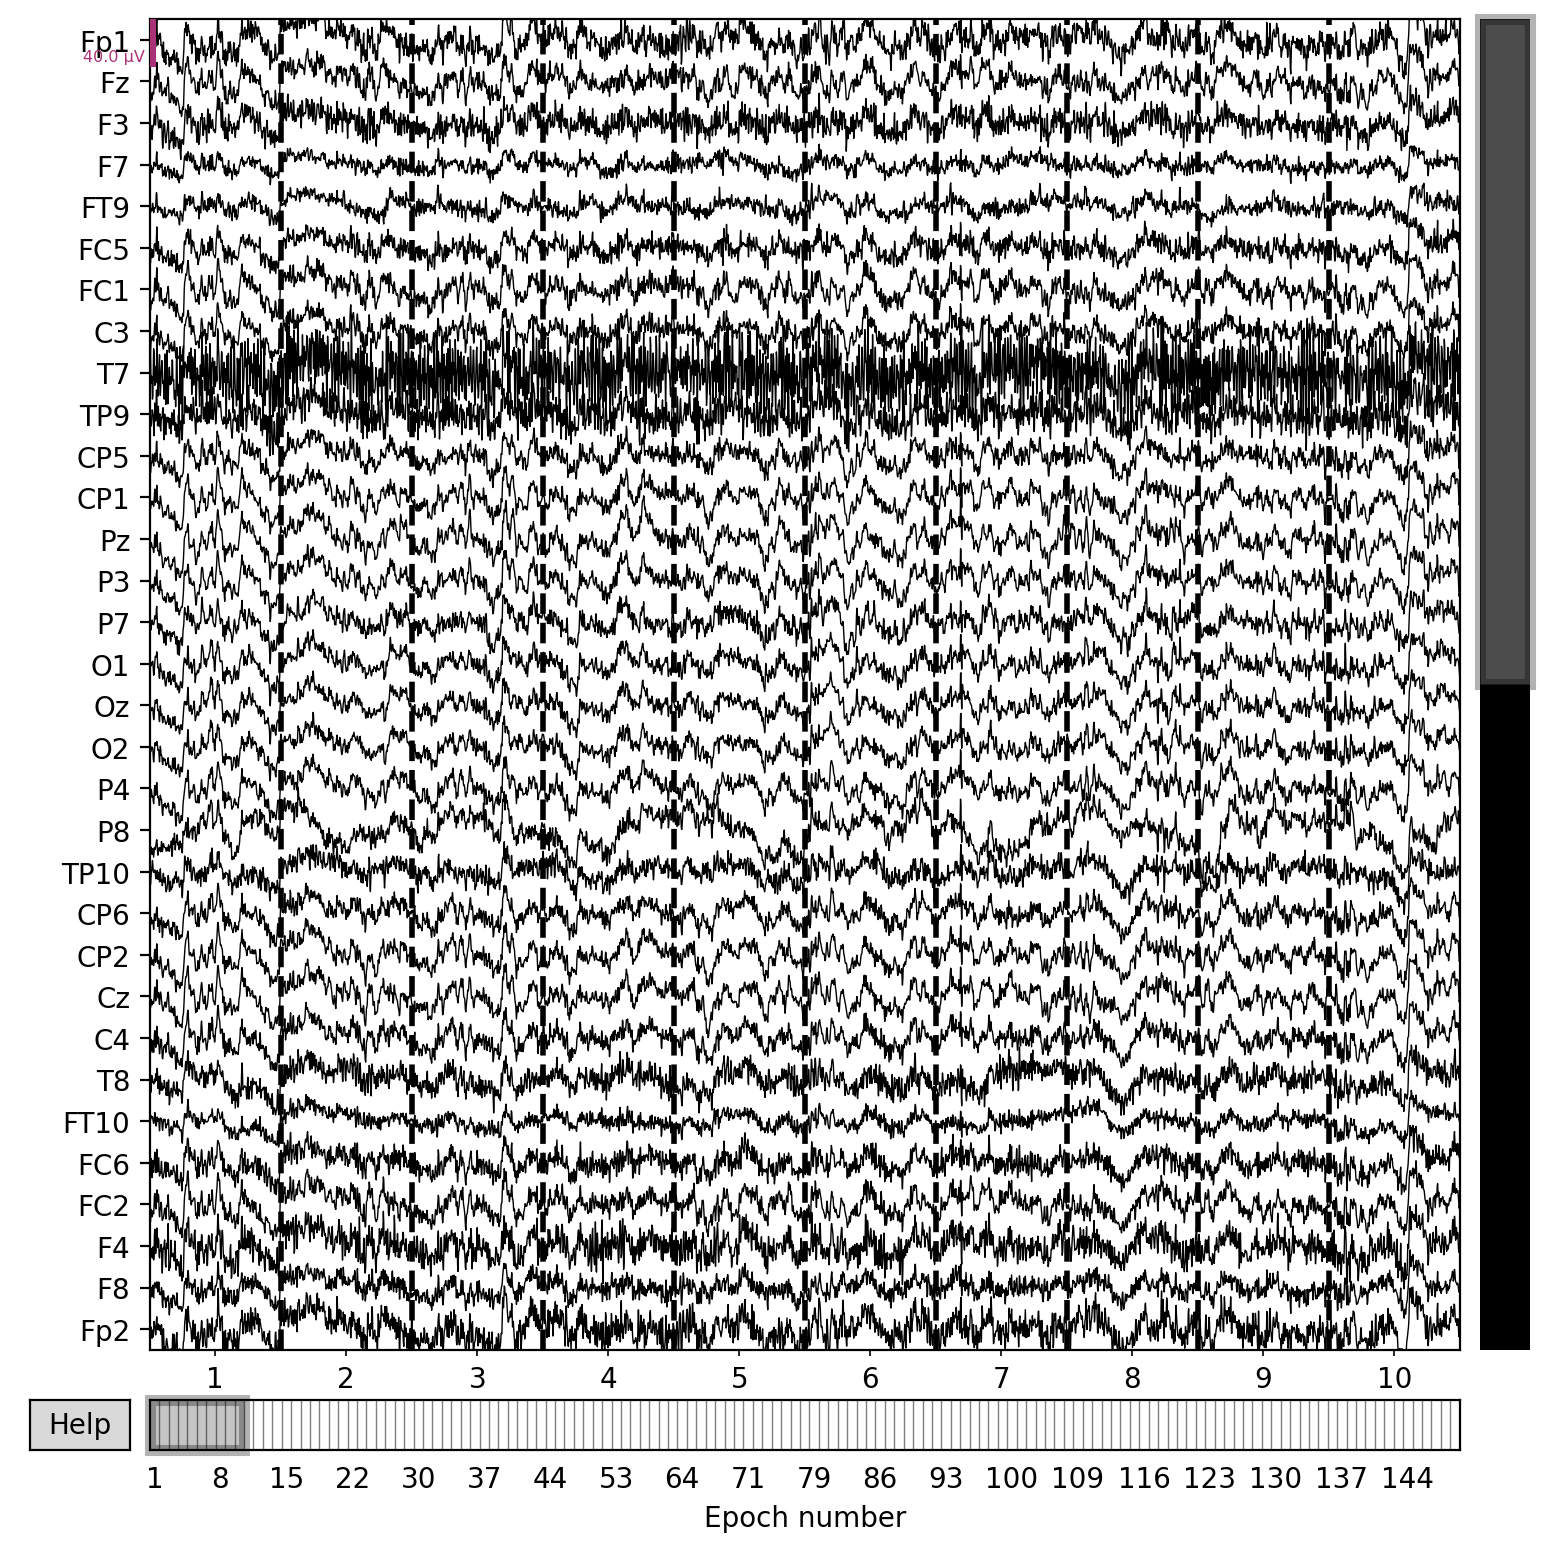

Dropped 0 epochs: 
Channels marked as bad: none


In [104]:
epochs_ica[subset].plot(n_epochs=10, n_channels=32, scalings={'eeg': 20e-6},)

### 1.4. Save cleaned epochs (recommended)

In [130]:
epochs_path

'/Users/weian/Downloads/Raw_data/preprocessed/epochs_rs'

In [131]:
epochs_ica.info["temp"]

'21_E_Day1_ICA'

In [132]:
os.path.join(epochs_path, f'{epochs_ica.info["temp"]}-epo.fif.gz')

'/Users/weian/Downloads/Raw_data/preprocessed/epochs_rs/21_E_Day1_ICA-epo.fif.gz'

In [133]:
epochs_ica.save(os.path.join(epochs_path, f'{epochs_ica.info["temp"]}-epo.fif.gz'),
                overwrite=True)

### 1.5. Create a log file 

We can create a log file for the preprocessed data and store metadata
that could be useful to remember. You can add more columns to this, or 
remove the ones that are not needed. For documentation purporses, it is 
recommended to store the number of rejected and total epochs, the number of
ICA components that were rejected, the number of interpolated electrodes etc.
You can also add a column with "notes" to add custom descriptions about the data.

In [134]:
notes = ''

In [135]:
log_file_path = os.path.join(os.path.join(epochs_path, 'log.csv'))

In [136]:
epochs_ica.info["temp"]

'21_E_Day1_ICA'

In [137]:
update_log(log_file_path, epochs_ica, notes)

fid  highpass  lowpass  n_components  n_bad_epochs  \
0  21_E_Day1_ICA       0.5     45.0           3.0            15   

   n_total_epochs  drop_percentage   stimuli  t_min  t_max  n_interpolated  \
0             285              5.0  [83, 87]    0.0    2.0             NaN   

   average_ref_applied  baseline notes              date_of_update  
0                False       NaN        2022-02-09T15:49:44.469880

### 2.1. Run autoreject

In [138]:
settings['autoreject']['threshold'] = 0.15

In [140]:
reject_log = run_autoreject(epochs_ica, subset=False)

Fitting autoreject on (n=285) epochs: 
Running autoreject on ch_type=eeg


  0%|          | Creating augmented epochs : 0/64 [00:00<?,       ?it/s]

  0%|          | Computing thresholds ... : 0/64 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/285 [00:00<?,       ?it/s]

  0%|          | n_interp : 0/3 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/285 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/285 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/285 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]





Estimated consensus=0.20 and n_interpolate=4

AUTOREJECT report
There are 39 bad epochs found with Autoreject. You can assess these epochs with reject_log.bad_epochs

There are 62 bad epochs where more than 15% of the channels were noisy. You can assess these epochs with reject_log.report


In [ ]:
reject_log.report

In [ ]:
# Here you can decide how strict should be the epoch rejection.
# You can drop only those that were marked as bad epochs, or a more 
# strict rejection threshold can be if you drop epochs where more than
# 15% of the channels were marked as noisy.

# You can plot the epochs with Autoreject, where bad epochs are marked with
# red colors. 

#reject_log.plot_epochs(epochs_faster)

In [141]:
epochs_autoreject = apply_autoreject(epochs=epochs_ica, reject_log=reject_log)

Dropped 62 epochs: 0, 2, 9, 10, 12, 18, 20, 21, 22, 24, 25, 31, 33, 34, 35, 37, 40, 44, 53, 55, 65, 66, 67, 68, 78, 79, 80, 82, 93, 97, 98, 134, 135, 139, 158, 161, 170, 171, 174, 180, 189, 194, 203, 205, 206, 207, 219, 222, 223, 228, 240, 241, 245, 246, 259, 266, 267, 270, 274, 275, 277, 284


In [ ]:
epochs_autoreject.info["temp"]

In [ ]:
os.path.join(epochs_path, f'{epochs_autoreject.info["temp"]}-epo.fif.gz')

In [142]:
epochs_autoreject.save(os.path.join(epochs_path, f'{epochs_autoreject.info["temp"]}-epo.fif.gz'), overwrite=True)

In [143]:
# Update log
notes = ''

update_log(log_file_path, epochs_autoreject, notes)

fid  highpass  lowpass  n_components  n_bad_epochs  \
0  21_E_Day1_ICA_autoreject       0.5     45.0           3.0            77   

   n_total_epochs  drop_percentage   stimuli  t_min  t_max  n_interpolated  \
0             223            25.67  [83, 87]    0.0    2.0             NaN   

   average_ref_applied  baseline notes              date_of_update  
0                False       NaN        2022-02-09T15:52:40.953559

### 3. Find and interpolate bad channels

In [144]:
bads = get_noisy_channels(epochs=epochs_autoreject, with_ransac=True)

Creating RawArray with float64 data, n_channels=64, n_times=223223
    Range : 0 ... 223222 =      0.000 ...   446.444 secs
Ready.
Executing RANSAC
This may take a while, so be patient...
Progress: 10%... 20%... 30%... 40%... 50%... 60%... 70%... 80%... 90%... 100%

RANSAC done!

NoisyChannels REPORT
------------------------
3.0% of the channels were detected as noisy.
(2) channels: TP7, T7


In [ ]:
#bads.extend(['T7', 'CPz'])

# .append() for string e.g. 'F7'
# .extend() for list ['F7', 'F8']

In [145]:
bads

['TP7', 'T7']

In [146]:
epochs_ransac = interpolate_bad_channels(epochs=epochs_autoreject, bads=bads)

Interpolating bad channels
    Automatic origin fit: head of radius 95.0 mm
Computing interpolation matrix from 62 sensor positions
Interpolating 2 sensors


In [147]:
print(epochs_ransac.info)

<Info | 10 non-empty values
 bads: []
 ch_names: Fp1, Fz, F3, F7, FT9, FC5, FC1, C3, T7, TP9, CP5, CP1, Pz, P3, ...
 chs: 64 EEG
 custom_ref_applied: False
 description: n_components: 3, interpolated: TP7, T7
 dig: 64 items (64 EEG)
 highpass: 0.5 Hz
 lowpass: 45.0 Hz
 meas_date: 2021-01-14 14:33:24 UTC
 nchan: 64
 projs: []
 sfreq: 500.0 Hz
 temp: 21_E_Day1_ICA_autoreject_ransac
>


## 4. Final visual inspection

Mark epochs that should be dropped,  etc.

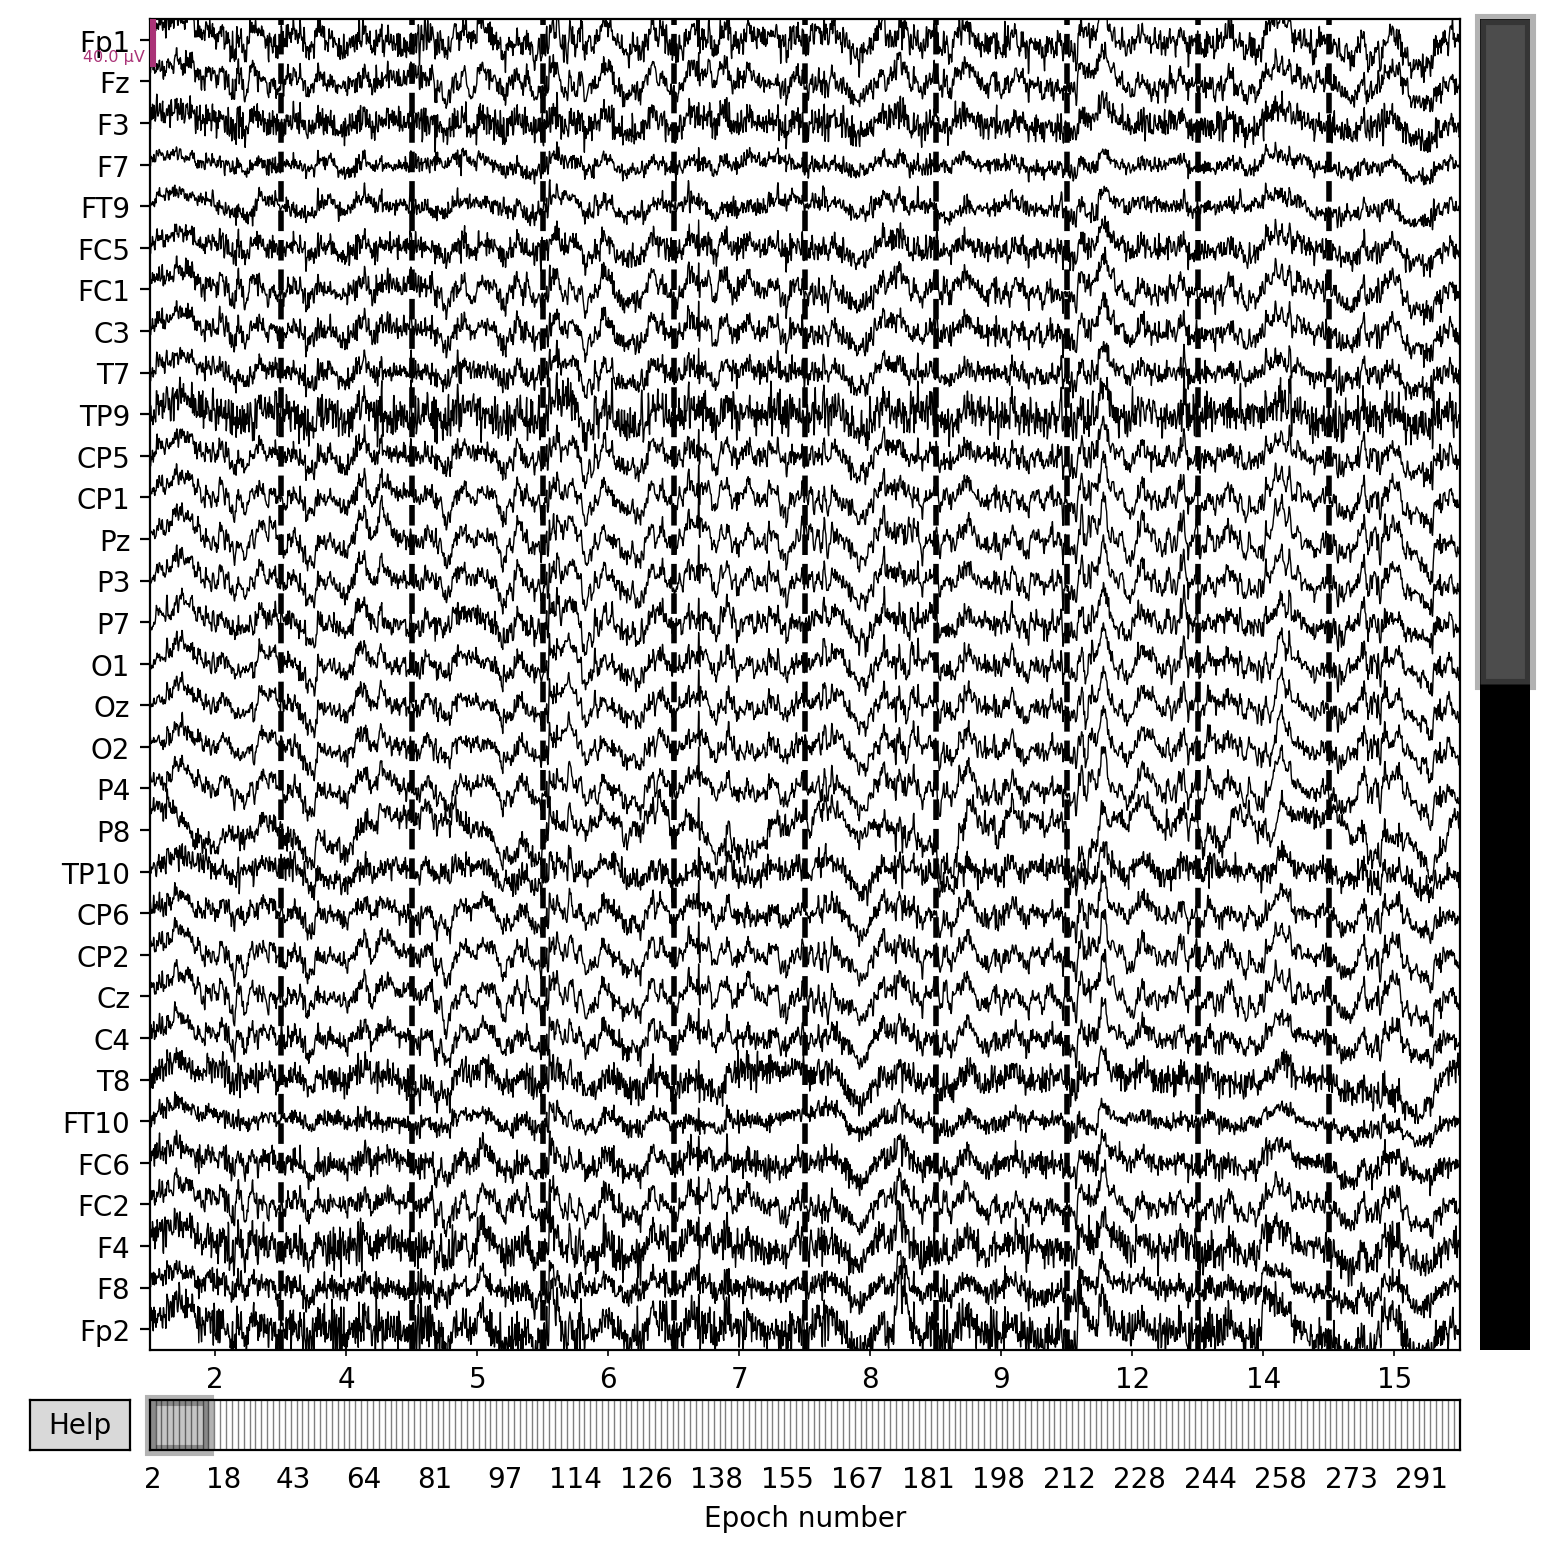

In [148]:
# # use indexing to plot fewer epochs (faster) e.g. [::7] shows only every 7th epoch
epochs_ransac.plot(n_epochs=10,
                       n_channels=32,
                # group_by='position',
                       scalings={'eeg': 20e-6})

### 5.2. Set average reference

To set a “virtual reference” that is the average of all channels, you can use set_eeg_reference() with ref_channels='average'.


In [149]:
epochs_ransac.set_eeg_reference('average')

EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


<Epochs |  223 events (all good), 0 - 2 sec, baseline off, ~109.1 MB, data loaded,
 '83': 106
 '87': 117>

## 6. Save cleaned epochs

In [150]:
os.path.join(epochs_path, f'{epochs_ransac.info["temp"]}-epo.fif.gz')

'/Users/weian/Downloads/Raw_data/preprocessed/epochs_rs/21_E_Day1_ICA_autoreject_ransac-epo.fif.gz'

In [171]:
epochs_ransac.save(os.path.join(epochs_path, f'{epochs_ransac.info["temp"]}-epo.fif.gz'), overwrite=True)

In [172]:
update_log(log_file_path, epochs_ransac, '')

fid  highpass  lowpass  n_components  \
0  21_E_Day1_ICA_autoreject_ransac       0.5     45.0           3.0   

   n_bad_epochs  n_total_epochs  drop_percentage   stimuli  t_min  t_max  \
0            77             223            25.67  [83, 87]    0.0    2.0   

   n_interpolated  average_ref_applied  baseline notes  \
0             2.0                 True       NaN         

               date_of_update  
0  2022-02-09T16:10:57.866220

In [51]:
ch_names = ['F7', 'F5', 'F3', 'FC5', 'FC3',
           'F1', 'Fz', 'F2', 'FC1', 'FCz', 'FC2',
           'F4', 'F6', 'F8', 'FC4', 'FC6',
           'FT7', 'T7', 'TP7', 
           'C3', 'Cz', 'C4',
           'FT8', 'T8', 'TP8',
           'CP5', 'CP3', 'P7', 'P5', 'P3',
           'CP1', 'CPz', 'CP2', 'P1', 'Pz', 'P2',
           'CP4', 'CP6', 'P4', 'P6', 'P8',
           'PO3', 'PO7', 'O1',
           'PO4', 'PO8', 'O2',]


epochs_evoked = epochs_ransac.copy().pick_channels(ch_names, ordered=True)

    Using multitaper spectrum estimation with 7 DPSS windows


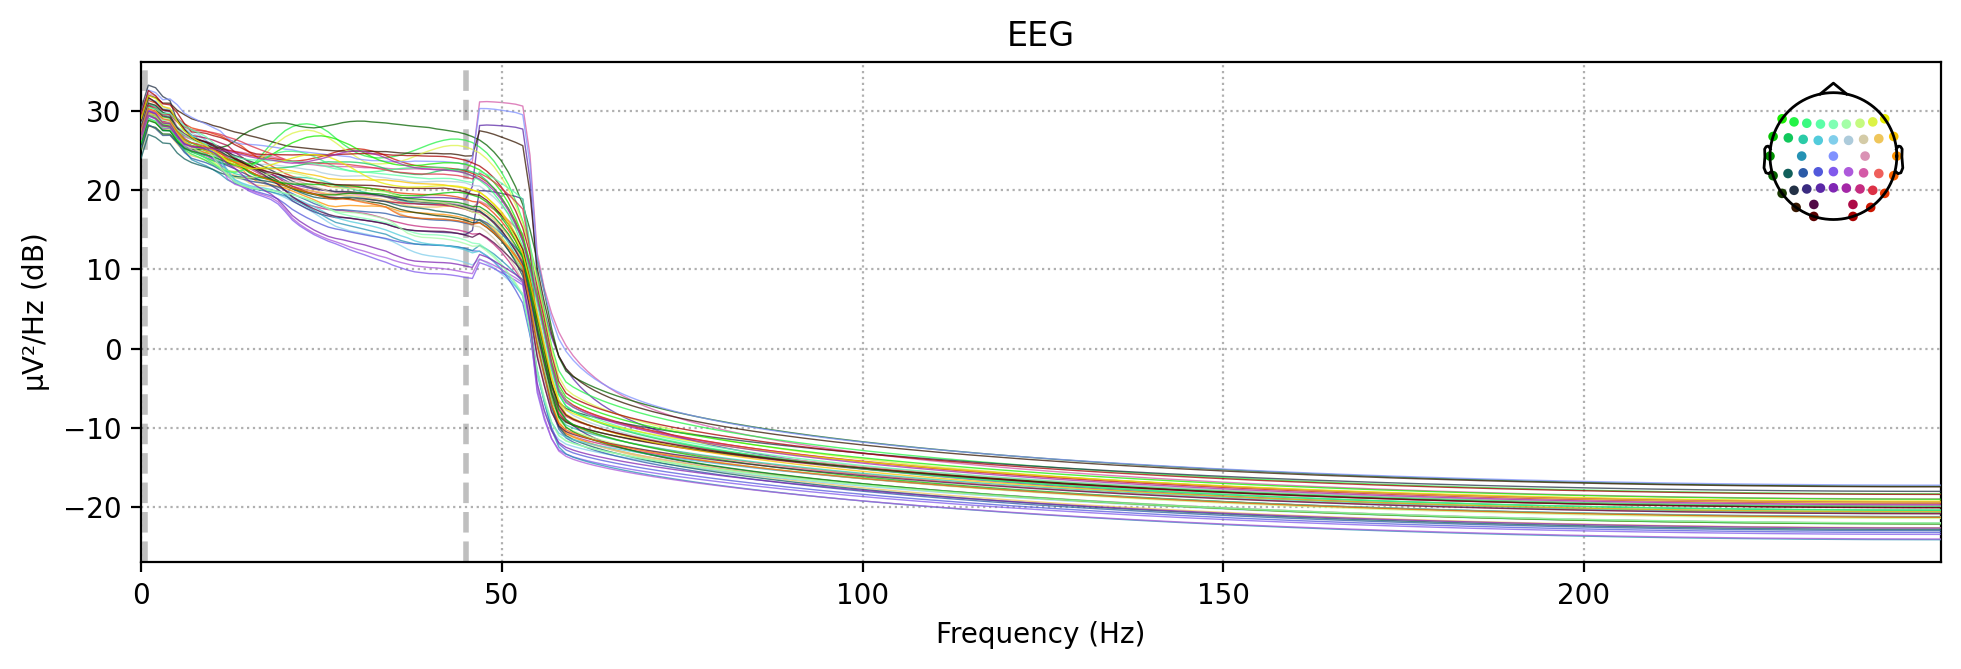

In [52]:
epochs_evoked.plot_psd() # set fmin fmax